#In this notebook, we perform numerical simulations for Bayesian logistic regression: we observe samples of pairs $\{(\boldsymbol{x}_n, y_n) \}_{n=1}^N$, where $\boldsymbol{x}_n\in\mathbb{R}^d$ and $y_n\in\{0,1\}$. The data are assumed to follow the model
$$
y_n \stackrel{\text{i.i.d.}}{\sim} \mathrm{Bernoulli}\!\left( \frac{\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)}{1+\exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)}\right)
$$
for $n\in\{1, \ldots, N\}$. The parameter $\boldsymbol{\theta} = (\theta_i)_{1 \leqslant i \leqslant d}^\top\in\mathbb{R}^d$ is a random variable with a prior density $\lambda$ with respect to Lebesgue measure. Then, the posterior distribution $\pi$ takes the form
$$p(\boldsymbol{\theta}\,|\,\{(\boldsymbol{x}_n, y_n) \}_{n=1}^N) \propto p(\boldsymbol{\theta}) \exp\left\lbrace\sum_{n=1}^N \left(y_n \langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle - \log (1 + \exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)) \right)\right\rbrace. $$

We can consider the case of an anisotropic Laplace prior (sparsity-inducing) and a prior in the form of a combination of an anisotropic Laplace distribution and an anisotropic Gaussian distribution, where the unadjusted Langevin algorithm is no longer viable. In general, such priors take the form:
$$ p(\boldsymbol{\theta})  : p(\boldsymbol{\theta}\,|\,\boldsymbol{\alpha}_1, \boldsymbol{\alpha}_2) \propto \exp\left(- \sum_{i=1}^d \alpha_{1,i}|\theta_i| - \sum_{i=1}^d \alpha_{2,i}\theta_i^2 \right) , $$
where $\boldsymbol{\alpha}_1 = (\alpha_{1,i})_{1\le i\le d}^\top\in\mathbb{R}_+^d$ and  $\boldsymbol{\alpha}_2 = (\alpha_{1,i})_{2\le i\le d}^\top\in\mathbb{R}_+^d$.

Then, the posterior distribution will have a potential in the following form:
$$
\sum_{n=1}^N \left[\log (1 + \exp(\langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle)) - y_n \langle \boldsymbol{\theta}, \boldsymbol{x}_n\rangle \right] + \sum_{i=1}^d \alpha_{1,i}|\theta_i| + \sum_{i=1}^d \alpha_{2,i}\theta_i^2
$$

j = 0
iteration 1: error = 3.687569016742729
iteration 100: error = 1.4033560814277108
iteration 200: error = 0.8970063876042934
iteration 300: error = 0.7455746555980314
iteration 400: error = 0.6444050277271787
iteration 500: error = 0.6601492969124564
iteration 600: error = 0.7954624000421162
iteration 700: error = 0.57043266401736
iteration 800: error = 0.6065047369697144
iteration 900: error = 0.7111073022331884
iteration 1000: error = 0.6075552011007709


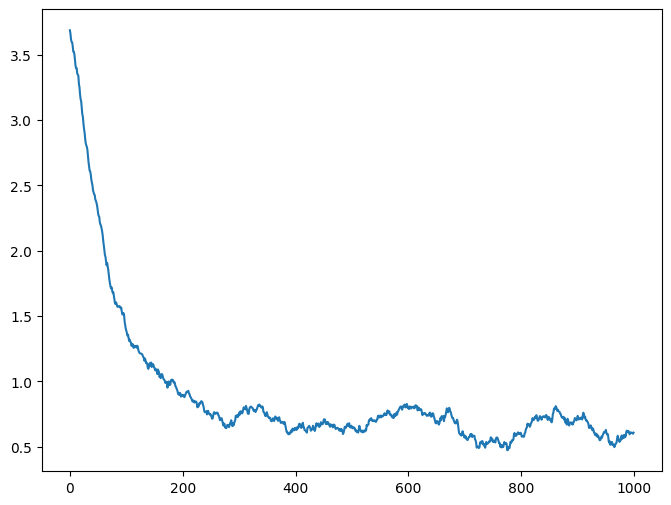

In [36]:
import matplotlib.pyplot as plt
#plt.style.use('science')

import numpy as np
import pandas as pd
import scipy
import scipy.special
from sklearn.model_selection import train_test_split


from numpy.random import default_rng
rng = default_rng()

# Set random seed for reproducibility
#np.random.seed(0)

# simulation of data points

d = 10
N = 1000

theta_star =  np.arange(10) / 10
theta_star = np.repeat(theta_star, d/10)

# Generate data
X = np.random.randn(d, N)
logit = np.exp(np.dot(theta_star, X)) / (1 + np.exp(np.dot(theta_star, X)))
Y = np.random.binomial(1, logit)

# Define the proportion of data to be used for testing
test_size = 0.2

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=test_size, random_state=42)

# Transpose X_train and X_test back to their original shapes
X_train = X_train.T
X_test = X_test.T

X, Y = X_train, Y_train


#Function to compute the gradient of the potential
def grad_potential(theta: np.ndarray,
                   X: np.ndarray,
                   Y: np.ndarray) -> np.ndarray:
    '''
    theta: d by 1 vector: parameter of the Bayesian logistic regression model
    X: d by N matrix: each column is X_n
    Y: N by 1 vector: each entry is Y_n
    '''
    return - np.einsum('i,ji->j', Y - scipy.special.expit(np.dot(theta, X)), X)

# Init

# to induce sparsity change decomment these lines
#alpha1 = np.arange(11)[11:0:-1]
#alpha1 = np.repeat(alpha1, 10)
#alpha2 = 0.1

np.zeros(100)
alpha2 = 0.5

#ULA

def ula(gamma, lam, alpha1, alpha2, X, Y, theta_star, seed, d=100, K=1000, print_freq=100):
    np.random.seed(seed)
    theta0 = np.random.normal(0, 1, d)
    theta = []
    error = []

    for i in range(K):
        xi = rng.multivariate_normal(np.zeros(d), np.eye(d))
        theta_new = theta0 - gamma * grad_potential(theta0, X, Y) + np.sqrt(2*gamma) * xi
        theta.append(theta_new)
        error.append(np.linalg.norm(theta_new - theta_star))
        if i == 0 or i % print_freq == print_freq - 1:
            print('iteration {}: error = {}'.format(i + 1, np.linalg.norm(theta_new - theta_star)))
        theta0 = theta_new

    return theta, error

# ULA Main Loop

S = 1
Theta1 = []
Error1 = []

K = 1000
gamma = 5e-4
gamma = 1e-4
#gamma = 5e-5
#gamma = 1e-5

for j in range(S):
    print('j =', j)
    theta1, error1 = ula(gamma, 1e-2, alpha1, alpha2, X, Y, theta_star, j, d, K)
    Theta1.append(theta1)
    Error1.append(error1)

theta1 = np.mean(np.array(Theta1), axis=0)
error1 = np.array([np.linalg.norm(theta1[i] - theta_star) for i in range(K)])

plt.figure(0, figsize=(8,6))
plt.plot(np.arange(K), error1)

In [37]:
# compute the Bayesian Model Averaged predictions


def predict_posterior_samples(theta_samples, X_test):
    """
    Predict labels for test data using samples from the posterior distribution.

    Parameters:
        theta_samples (ndarray): Samples from the posterior distribution of parameters.
        X_test (ndarray): Test data features.

    Returns:
        ndarray: Predicted labels for test data.
    """
    num_samples = len(theta_samples)
    num_test_points = X_test.shape[1]
    predictions = np.zeros(num_test_points)

    for theta in theta_samples:
        logit = np.exp(np.dot(theta, X_test)) / (1 + np.exp(np.dot(theta, X_test)))
        sample_predictions = (logit > 0.5).astype(int)
        predictions += sample_predictions

    average_predictions = predictions / num_samples
    return np.round(average_predictions)


# Assuming you have your test data in X_test and true labels in Y_test
# Predict labels using posterior samples
predicted_labels = predict_posterior_samples(theta1, X_test)

# Compute accuracy
accuracy = np.mean(predicted_labels == Y_test)
print("Accuracy:", accuracy)



Accuracy: 0.72


1) You can play with different hyperparameters: the dimension of the problem, the step-size, the number of iterations. How does the algorithm behave? You should notice similar problems as for gradient descent.

2) You can go further by playing with the sparsity of the prior distribution and test the Moreau-Yosida version of LMC (see https://github.com/timlautk/bregman_prox_langevin_mc/blob/main/notebook/sampling_bayesian_logistic_reg.ipynb).